# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

In [1]:
!pip install --upgrade scikit-learn

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import logging
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.core.display import display, HTML
from matplotlib import rcParams, rcParamsDefault
from scipy.stats import pointbiserialr
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import QuantileTransformer, RobustScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.dummy import DummyClassifier

display(HTML("<style>div.outputscroll { height: 44em; }</style>"))


## Откройте и изучите файл

In [5]:
logging.basicConfig(filename='app.log', level=logging.INFO)

In [6]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except FileNotFoundError as f_e:
    print('Файл не найден')
    logging.error(str(f_e))
except UnicodeDecodeError as u_e: 
    print('Ошибка в кодировке')
    print(str(u_e))
    logging.error(str(u_e))
except ValueError as v_e: 
    print('Ошибка в типах данных')
    print(str(v_e))
    logging.error(str(v_e))


In [7]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


Сразу можно заметить, что размерности силльно отличаются

In [8]:
df.tail()

,calls,minutes,messages,mb_used,is_ultra
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0
3213,80.0,566.09,6.0,29480.52,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Так как данные уже подготовленные, то естественно, что все впорядке  
  
  
Кол-во объектов - 3214 должно быть достаточным, чтобы решить бинарную категориальную задачу. 

In [10]:
df.sample(5)

,calls,minutes,messages,mb_used,is_ultra
2663,60.0,449.57,0.0,20700.96,0
37,64.0,422.69,0.0,11460.29,0
2862,74.0,589.16,49.0,17279.27,1
1545,30.0,166.51,77.0,12199.43,0
433,54.0,424.61,66.0,22395.62,0


Сделал сэмплы, чтобы как дополнительный маркер посмотреть на разброс между признаками

In [11]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Окончательно про масштаб признаков : 

**calls**   
  
Значения от 0 до 244  звонков  
Расстояние между 25ым и 75ым квартилями равняется 42 звонка
Медиана равняется 62 звонкам  
  
**minutes** 
  
Значения от 0 до 1632  минут   
Расстояние между 25ым и 75ым квартилями равняется 298 минутам  
Медиана равняется 430 минутам    
  
  
**messages**   
  
Значения от 0 до 224  сообщений   
Расстояние между 25ым и 75ым квартилями равняется 48 сообщений  
Медиана равняется 30 сообщений  


**mb_used**  
  
Значения от 0 до 12491  Мб   
Расстояние между 25ым и 75ым квартилями равняется 8933 Мб  
Медиана равняется 16943.23 Мб  
  
  
**Вывод про масштаб :**  
признаки отличаются в $10^0..10^4$ раз, что делает опасным использование таких данных для некоторых моделей(например логистическая регрессия)

In [12]:
corr_matrix = df.loc[:,'calls':'mb_used'].corr()

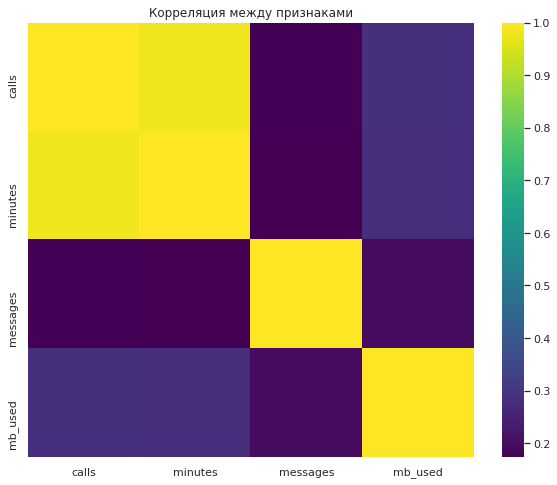

In [13]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.heatmap(corr_matrix, cmap='viridis')
plt.title('Корреляция между признаками')
plt.show()

1) calls  
    1.1) minutes - имеют 'весьма высокую' линейную связь, что и логично, так как чем чаще человек тем больше минут тратит  
    1.2) messages, mb_used - имеют слабую линейную связь, что так же кажется логичным  
2) minutes  
    2.1) messages, mb_used - имеют слабую линейную связь, что так же кажется логичным  
3) messages  
    2.1)mb_used- имеют слабую линейную связь, что так же кажется логичным  

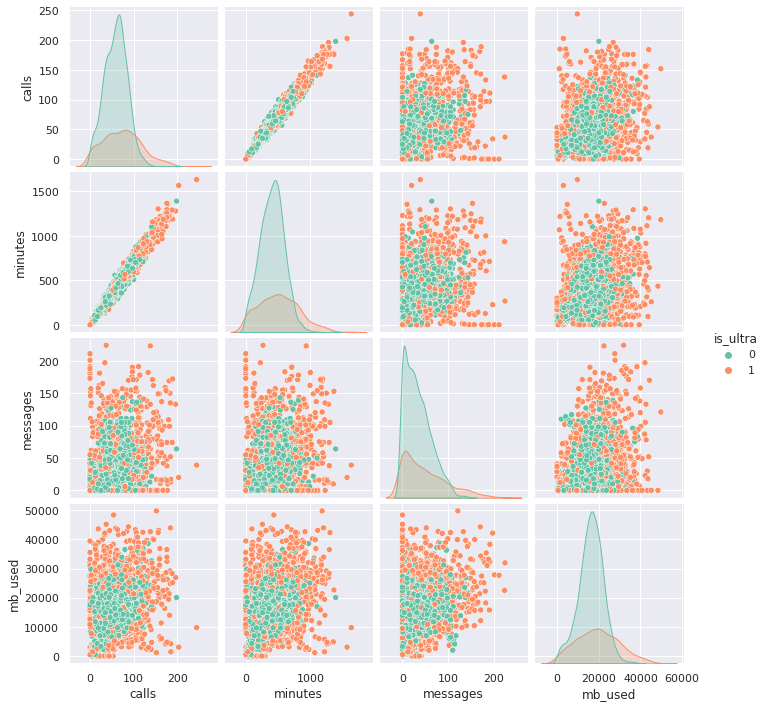

In [14]:
sns.set(rc = {'figure.figsize':(10,8)})
sns.pairplot(data=df,hue='is_ultra',diag_kind='kde',palette="Set2")
    
plt.show()

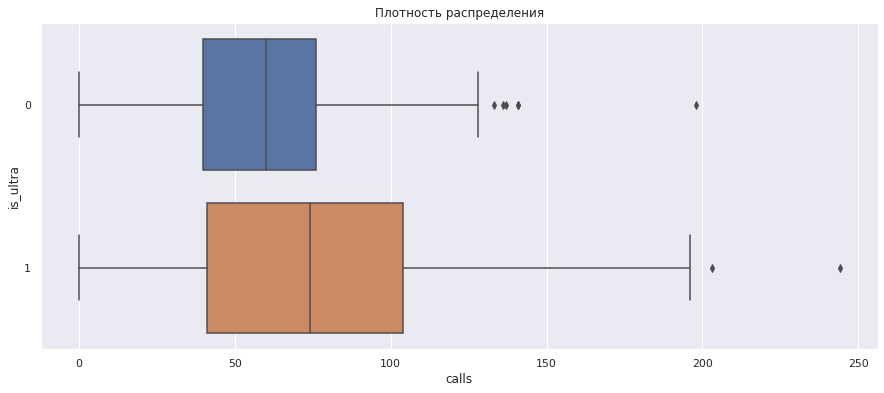

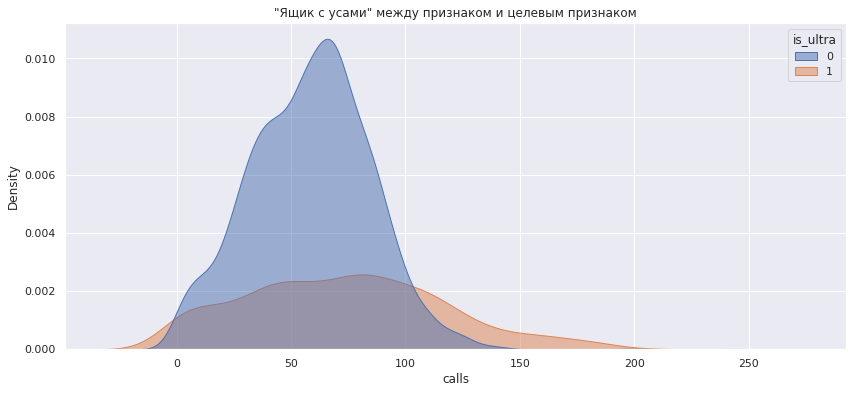

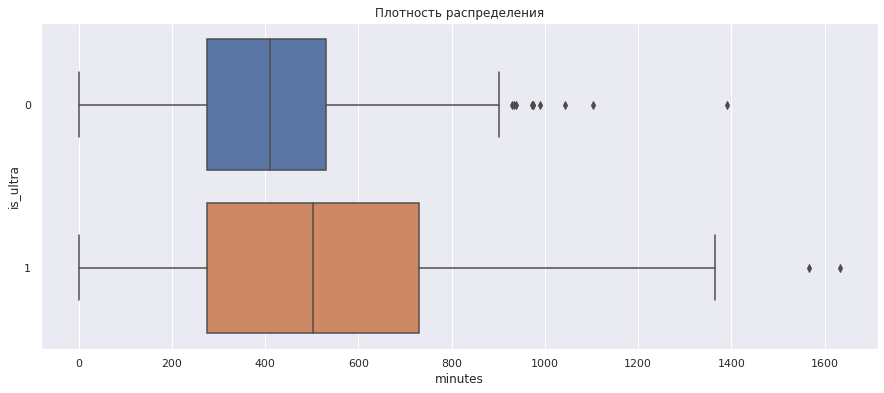

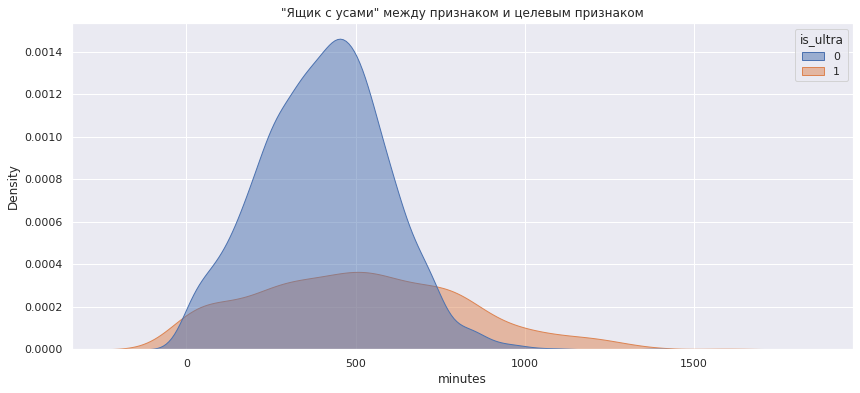

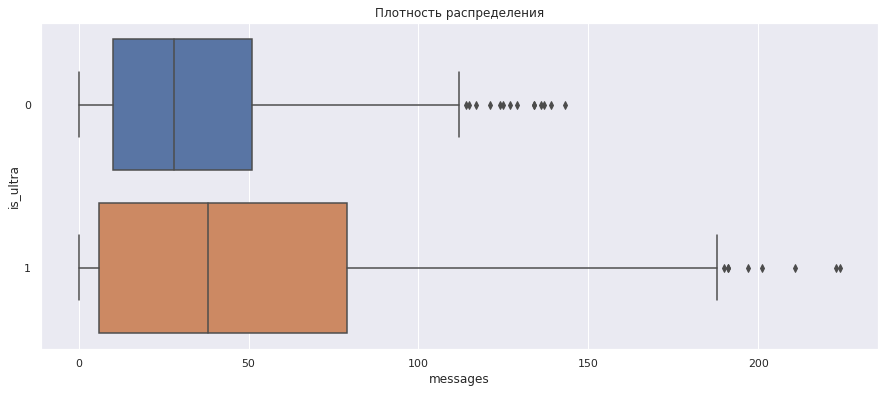

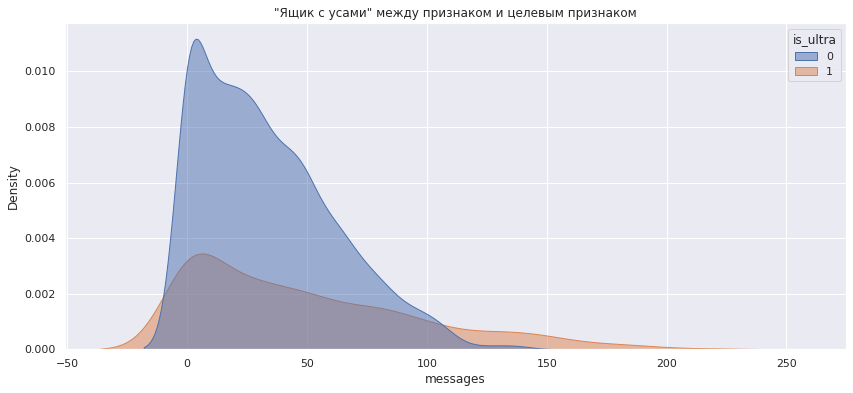

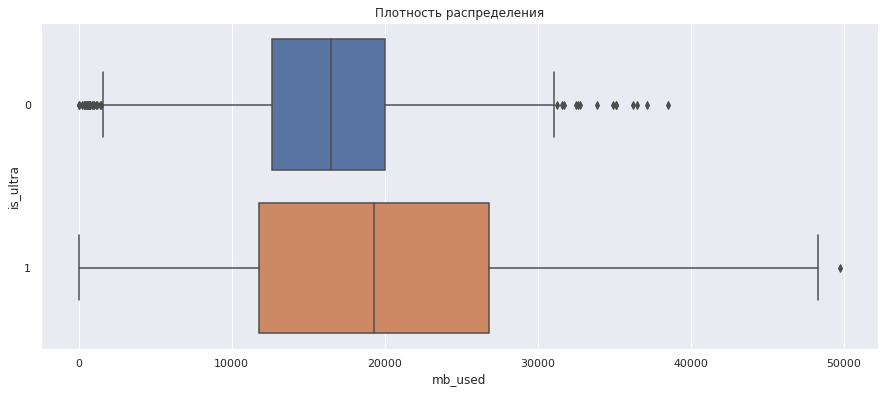

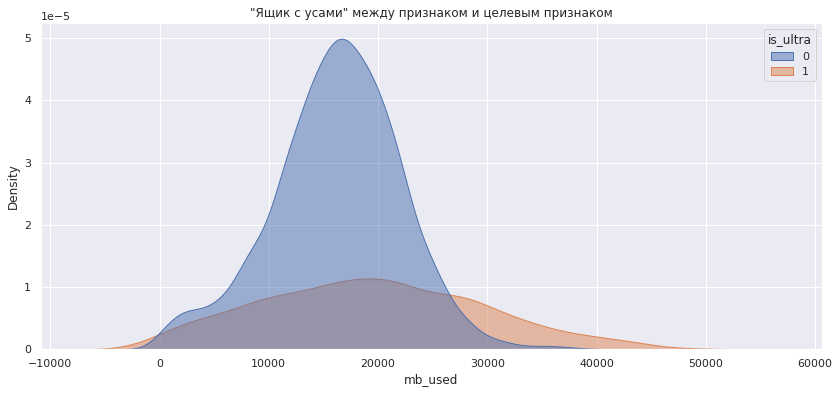

In [15]:
for i in list(df.loc[:,'calls':'mb_used'].columns):
    plt.figure(figsize=(15,6))

    sns.boxplot(x=i,y='is_ultra',data=df,orient='h')
    plt.title('Плотность распределения')
    plt.show()
    
    plt.figure(figsize=(14,6))

    sns.kdeplot(data=df, x=i, hue="is_ultra",fill=True, alpha=.5)
    plt.title('"Ящик с усами" между признаком и целевым признаком')
    plt.show()

- По графику зависимостей можно наблюдать, что для части пользователей ультры есть характерное присутсвие на границах скопления смарта -> что может помочь в распозновании.  
- Так же можно наблюдать линейность выявленную ранее между minutes и calls.  
- Можно также отметить скос распределения сообщений, что еще раз подтверждает, важность масштабирования  
- Есть тенденция к более активному пользованию услугами у ультры  

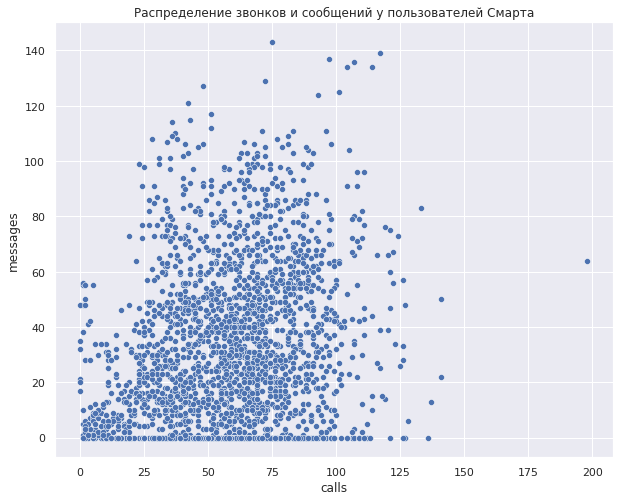

In [16]:
plt.figure(figsize=(10,8))
sns.scatterplot(x = 'calls', y='messages',data=df[df['is_ultra']==0])
plt.title('Распределение звонков и сообщений у пользователей Смарта')
plt.show()

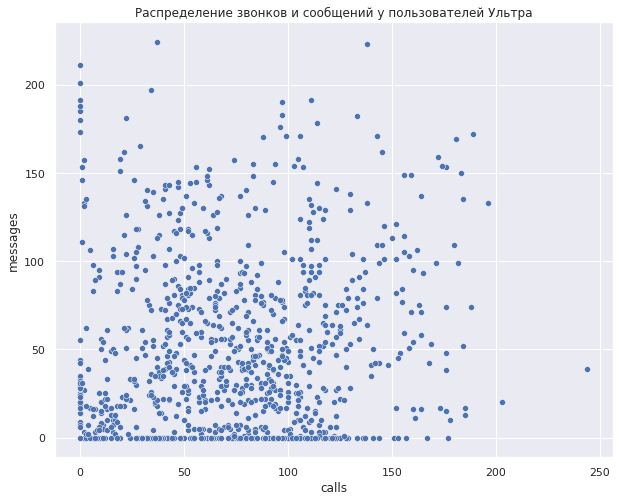

In [17]:
plt.figure(figsize=(10,8))

sns.scatterplot(x = 'calls', y='messages',data=df[df['is_ultra']==1])
plt.title('Распределение звонков и сообщений у пользователей Ультра')
plt.show()

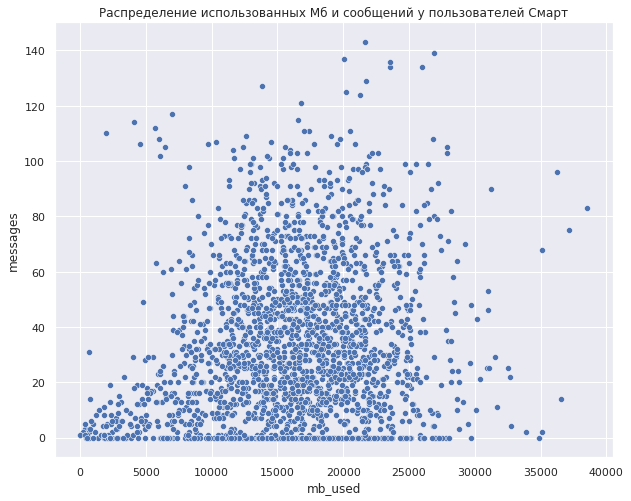

In [18]:
plt.figure(figsize=(10,8))

sns.scatterplot(x = 'mb_used', y='messages',data=df[df['is_ultra']==0])
plt.title('Распределение использованных Мб и сообщений у пользователей Смарт')
plt.show()

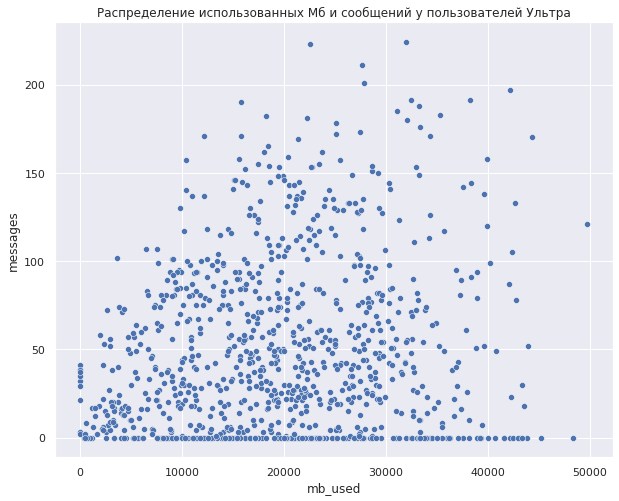

In [19]:
plt.figure(figsize=(10,8))

sns.scatterplot(x = 'mb_used', y='messages',data=df[df['is_ultra']==1])
plt.title('Распределение использованных Мб и сообщений у пользователей Ультра')
plt.show()

Мне было интересно посмотреть поближе на те графики, которые на первый взгляд мне показали, что есть некоторое распределение Ультры около Смарта, что еще раз подтвердилось, после чего написал следующую фичу

In [20]:
ex = df['calls'] * df['messages'] * df['mb_used'] + df['calls'] + (df['messages'])**2 + (df['mb_used'])**2

In [21]:
corr, p_value = pointbiserialr(ex,df['is_ultra'])

In [22]:
selected_nums_cols = df.loc[:,'calls':'mb_used']
corr_list = []
for col in selected_nums_cols[1:]:
    corr, p_value = pointbiserialr(df[col],df['is_ultra'])
    corr_list.append(corr)

In [23]:
print(corr_list)

[0.20712155898607568, 0.20695463812169518, 0.20382983853553638, 0.19856764561974266]


Корреляция между целевым признаком и признаками - слабая. То есть можем скзать, что признаки напрямую не коррелируют c целевым.

In [24]:
df1 = df['is_ultra'].value_counts()
df1 = df1.reset_index()
df1.rename({'is_ultra': 'Количество', 'index': 'Тип тарифа'}, axis='columns', inplace=True)

In [25]:
df1

,Тип тарифа,Количество
0,0,2229
1,1,985


In [26]:
df1.loc[0,'Количество']/df1['Количество'].sum()

0.693528313627878

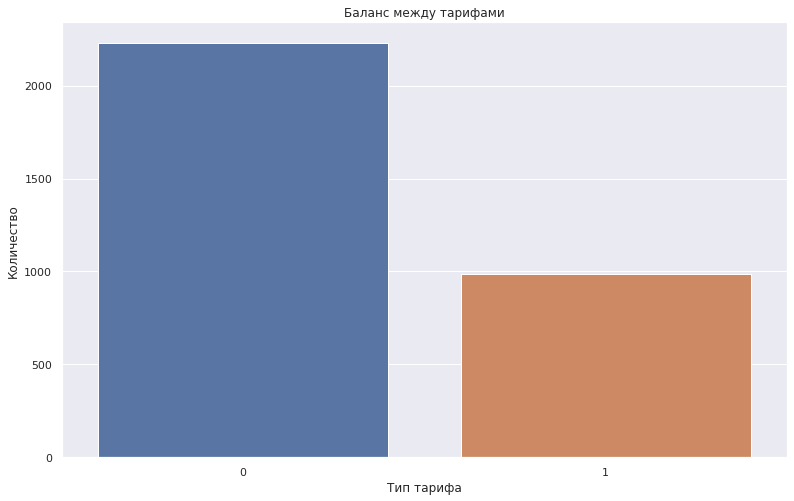

In [27]:
plt.figure(figsize=(13,8))

sns.barplot(x='Тип тарифа', y='Количество', data=df1)
plt.title('Баланс между тарифами')
plt.show()

Классы относительно сбалансированы

- Признаки напрямую не коррелируют c целевым.  
  
- Часть пользователей ультры присутсвуют на границах скопления смарта  
  
  
1) calls  
    1.1) minutes - имеют 'весьма высокую' линейную связь  
    1.2) messages, mb_used - имеют слабую линейную связь  
2) minutes  
    2.1) messages, mb_used - имеют слабую линейную связь  
3) messages  
    2.1)mb_used- имеют слабую линейную связь  
  
   
Размерности признаков отличаются в $10^0..10^4$ раз, что делает опасным использование таких данных для некоторых моделей(например логистическая регрессия)  

## Разбейте данные на выборки

In [28]:
X = df.loc[:,'minutes':'mb_used'] #minutes X = df.loc[:,'minutes':'mb_used'] #minutes
X['new'] = ex
y = df['is_ultra']
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scaler =  RobustScaler() #StandardScaler()

X_train_n_splits = []
y_train_n_splits = []
X_valid_n_splits = []
y_valid_n_splits = []
X_test_n_splits = []
y_test_n_splits = []



for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index,:], X.loc[test_index,:]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
    
    X_train_n_splits.append(X_train)
    y_train_n_splits.append(y_train)
    X_valid_n_splits.append(X_valid)
    y_valid_n_splits.append(y_valid)
    X_test_n_splits.append(X_test)
    y_test_n_splits.append(y_test)
    
    
l1 = [X_train_n_splits, y_train_n_splits, X_valid_n_splits, y_valid_n_splits, X_test_n_splits, y_test_n_splits]
[len(i) for i in l1]


[10, 10, 10, 10, 10, 10]

In [29]:
[[print(i.shape) for i in j] for j in l1]
l1.clear

(2169, 4)
(2169, 4)
(2169, 4)
(2169, 4)
(2169, 4)
(2169, 4)
(2169, 4)
(2169, 4)
(2169, 4)
(2169, 4)
(2169,)
(2169,)
(2169,)
(2169,)
(2169,)
(2169,)
(2169,)
(2169,)
(2169,)
(2169,)
(723, 4)
(723, 4)
(723, 4)
(723, 4)
(724, 4)
(724, 4)
(724, 4)
(724, 4)
(724, 4)
(724, 4)
(723,)
(723,)
(723,)
(723,)
(724,)
(724,)
(724,)
(724,)
(724,)
(724,)
(322, 4)
(322, 4)
(322, 4)
(322, 4)
(321, 4)
(321, 4)
(321, 4)
(321, 4)
(321, 4)
(321, 4)
(322,)
(322,)
(322,)
(322,)
(321,)
(321,)
(321,)
(321,)
(321,)
(321,)


<function list.clear()>

По размерностям все ок

**Вывод:**  
Данные были разбиты на 10 фолдов для проведения кросс-валидации. Каждый фолд был разбит на тренировочное, тестовое и валидационное множества. Была выполнена проверка на соответствие количеству и размерностям.  
Был использован метод масштабирования RobustScaler для уменьшения влияния разброса масштаба признаков и отсутствия у некоторых нормального распределения     

Из рассмотрения убран calls из-за линейной связи с minutes  

## Исследуйте модели

In [30]:
def train_model_n_get_accuracy_wrapper(X_train, y_train, X_valid, y_valid):
    def inner_train_func(model, switch):
        X_train_scaled = scaler.fit_transform(X_train)
        model.fit(X_train_scaled, y_train)
        X_valid_scaled = scaler.fit_transform(X_valid)
        
        preds = model.predict(X_valid_scaled)
        accuracy = np.round((preds == y_valid).sum()/y_valid.shape[0],3)
        if switch == 1:
            preds_proba = model.predict_proba(X_valid_scaled)[:,1]
            return accuracy, model,preds, preds_proba
        return accuracy, model
    return inner_train_func



In [31]:
res_df = []
res_conf = []

In [32]:
acuracy_logreg_max = 0
acuracy_knn_max = 0
acuracy_dt_max = 0
acuracy_rf_max = 0


100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


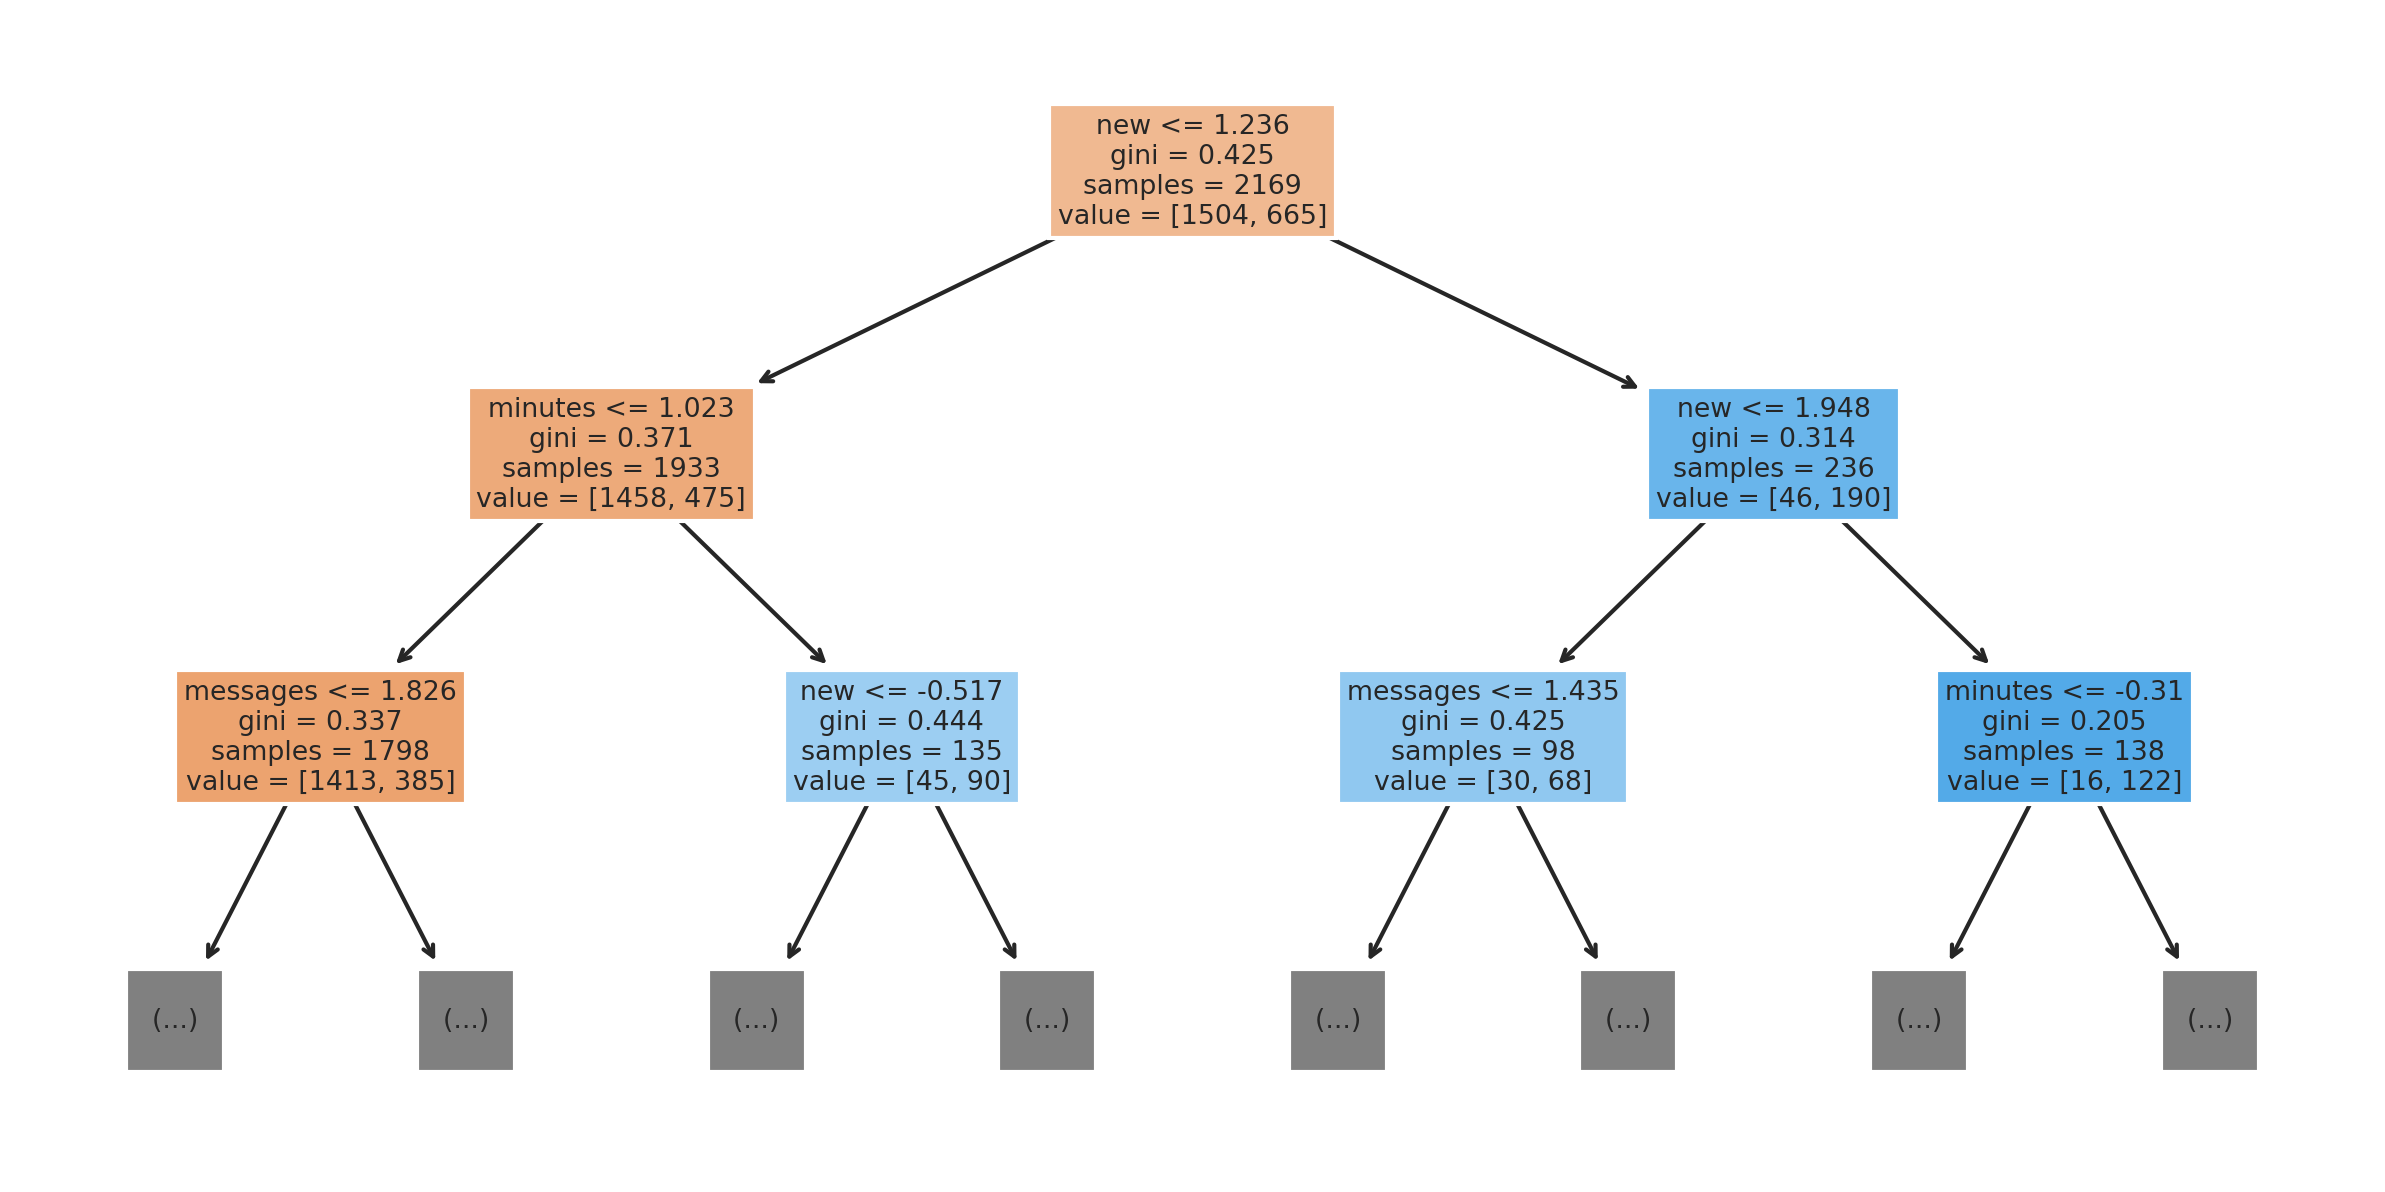

In [33]:
for i in tqdm(range(10), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}',colour='red') : 
    get_accuracy_func = train_model_n_get_accuracy_wrapper(X_train_n_splits[i],y_train_n_splits[i],
                                                                   X_valid_n_splits[i],y_valid_n_splits[i])
    acuracy_logreg, model_logreg = get_accuracy_func(LogisticRegression(max_iter =10000,solver='liblinear',penalty='l1',
                                                                           C=100,random_state=42),0)
    if acuracy_logreg > acuracy_logreg_max:
                acuracy_logreg_max = acuracy_logreg
    
    for j in range(10,50,10):
        for k in range(5,15,1):   
            acuracy_knn, model_knn = get_accuracy_func(KNeighborsClassifier(n_neighbors=k, leaf_size=j),0)
            acuracy_dt, model_dt = get_accuracy_func(DecisionTreeClassifier(random_state=42, max_depth=k),0)
            acuracy_rf, model_rf = get_accuracy_func(RandomForestClassifier(random_state=42, n_estimators=j, max_depth=k),0)
    


            if acuracy_knn > acuracy_knn_max:
                acuracy_knn_max = acuracy_knn
                knn_conf = [j,k]
                
                
            if acuracy_dt > acuracy_dt_max:
                acuracy_dt_max = acuracy_dt
                dt_conf = [j,k]
                

            if acuracy_rf > acuracy_rf_max:
                acuracy_rf_max = acuracy_rf
                rf_conf = [j,k]
            
    
            if (i == 5) and (j==20) and (k == 6) : 
                fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), dpi=300)
                feature_names = X_valid_n_splits[5].columns.to_list()
                plot_tree(model_dt, feature_names=feature_names, filled=True,  max_depth=2)
                
    res_df.append([i+1, acuracy_logreg, acuracy_knn_max, acuracy_dt_max, acuracy_rf_max])#, acuracy_lgbm])
    res_conf.append([i+1, knn_conf,dt_conf,rf_conf])
    

In [34]:
res_df 

[[1, 0.77, 0.798, 0.809, 0.823],
 [2, 0.769, 0.804, 0.809, 0.823],
 [3, 0.736, 0.804, 0.809, 0.823],
 [4, 0.77, 0.804, 0.809, 0.823],
 [5, 0.772, 0.805, 0.809, 0.823],
 [6, 0.778, 0.808, 0.809, 0.823],
 [7, 0.753, 0.808, 0.809, 0.823],
 [8, 0.76, 0.808, 0.809, 0.823],
 [9, 0.767, 0.809, 0.809, 0.823],
 [10, 0.768, 0.809, 0.809, 0.823]]

In [35]:
res_conf

[[1, [10, 13], [10, 6], [40, 6]],
 [2, [10, 12], [10, 6], [40, 6]],
 [3, [10, 12], [10, 6], [40, 6]],
 [4, [10, 12], [10, 6], [40, 6]],
 [5, [10, 14], [10, 6], [40, 6]],
 [6, [10, 11], [10, 6], [40, 6]],
 [7, [10, 11], [10, 6], [40, 6]],
 [8, [10, 11], [10, 6], [40, 6]],
 [9, [10, 14], [10, 6], [40, 6]],
 [10, [10, 14], [10, 6], [40, 6]]]

**Вывод :** 
Были использованы четыре метода обучения : 
1) Логистическая регрессия - показала худшее качество, но от заданный порог 0.75, метод не смог преодолеть только на одном фолде. среднее знаечние accuracy = 0.7639   
2) KNN -  среднее знаечние accuracy = 0.8058  
3) Решающее дерево - близок к случайному лесу. среднее знаечние accuracy = 0.8090  
4) Случайный лес - показал лучшее качество. среднее знаечние accuracy = 0.8230  
Рекомендовано использовать Random Forest

## Проверьте модель на тестовой выборке

In [36]:
train_final_X = pd.concat([X_train_n_splits[8],X_valid_n_splits[8]])
train_final_y = pd.concat([y_train_n_splits[8],y_valid_n_splits[8]])

get_accuracy_func = train_model_n_get_accuracy_wrapper(train_final_X,
                                                       train_final_y,
                                                       X_test_n_splits[8],
                                                       y_test_n_splits[8])


acuracy_logreg, model_logreg = get_accuracy_func(LogisticRegression(max_iter =10000,
                                                                    solver='liblinear',
                                                                    penalty='l1',
                                                                    C=100,random_state=42),0)


acuracy_rf, model_rf = get_accuracy_func(RandomForestClassifier(random_state=42,
                                                                n_estimators=40,
                                                                max_depth=6),0)


acuracy_knn, model_knn,preds_knn, preds_proba_knn = get_accuracy_func(KNeighborsClassifier(n_neighbors=11, 
                                                                                           leaf_size=10),1)

    
acuracy_dt, model_dt,preds_dt, preds_proba_dt = get_accuracy_func(DecisionTreeClassifier(random_state=42, 
                                                                                         max_depth=6),1)

In [37]:
print(f'Модель - логистическая регрессия')
print(f'Accuracy объединенных train и validation множеств :{acuracy_logreg}')

Модель - логистическая регрессия
Accuracy объединенных train и validation множеств :0.788


In [38]:
print(f'Модель - случайный лес')
print(f'Accuracy объединенных train и validation множеств :{acuracy_rf}')

Модель - случайный лес
Accuracy объединенных train и validation множеств :0.819


In [39]:
print(f'Модель - решающее дерево')
print(f'Accuracy объединенных train и validation множеств :{acuracy_dt}')

Модель - решающее дерево
Accuracy объединенных train и validation множеств :0.794


In [40]:
print(f'Модель - KNN')
print(f'Accuracy объединенных train и validation множеств :{acuracy_knn}')

Модель - KNN
Accuracy объединенных train и validation множеств :0.822


In [41]:

get_accuracy_func = train_model_n_get_accuracy_wrapper(X_train_n_splits[8],
                                                       y_train_n_splits[8],
                                                       X_test_n_splits[8],
                                                       y_test_n_splits[8])


acuracy_logreg, model_logreg = get_accuracy_func(LogisticRegression(max_iter =10000,
                                                                    solver='liblinear',
                                                                    penalty='l1',
                                                                    C=100,random_state=42),0)


acuracy_rf, model_rf = get_accuracy_func(RandomForestClassifier(random_state=42,
                                                                n_estimators=40,
                                                                max_depth=6),0)


acuracy_knn, model_knn,preds_knn, preds_proba_knn = get_accuracy_func(KNeighborsClassifier(n_neighbors=11, 
                                                                                           leaf_size=10),1)

    
acuracy_dt, model_dt,preds_dt, preds_proba_dt = get_accuracy_func(DecisionTreeClassifier(random_state=42, 
                                                                                         max_depth=6),1)

In [42]:
print(f'Модель - логистическая регрессия')
print(f'Accuracy на train мн-ве :{acuracy_logreg}')

Модель - логистическая регрессия
Accuracy на train мн-ве :0.782


In [43]:
print(f'Модель - случайный лес')
print(f'Accuracy на train мн-ве :{acuracy_rf}')

Модель - случайный лес
Accuracy на train мн-ве :0.816


In [44]:
print(f'Модель - решающее дерево')
print(f'Accuracy на train мн-ве :{acuracy_dt}')

Модель - решающее дерево
Accuracy на train мн-ве :0.804


In [45]:
print(f'Модель - KNN')
print(f'Accuracy на train мн-ве :{acuracy_knn}')

Модель - KNN
Accuracy на train мн-ве :0.826


**Вывод :**  
По результатам тестирования моделей с задачей бинарной классификации были получены следующие  значения accuracy:   
- Логистическая регрессия: 0.788 - (обучение на объединенных train и validation) 
- KNN: 0.826 - (обучение train)
- Дерево решений: 0.804  - (обучение train)
- Случайный лес: 0.819  (обучение на объединенных train и validation) 
  
Среди всех моделей наибольшее значение accuracy на тестовой выборке показал KNN - 0.826.   
Модель Случайный лес также близка к этому значению -  0.819

При важности метрики accuracy можно рекомендовать использовать случайный лес или KNN.  
Если важна скорость, а не важны качество, то лучшим вариантом станет - Логистическая регрессия.



## (бонус) Проверьте модели на адекватность

In [46]:
# По сути в масштаб им не надо, но так выглядит менее громоздко

get_accuracy_func = train_model_n_get_accuracy_wrapper(X_train_n_splits[8], 
                                                       y_train_n_splits[8], 
                                                       X_test_n_splits[8], 
                                                       y_test_n_splits[8])

acuracy_dummy, model_dummy = get_accuracy_func(DummyClassifier(strategy='most_frequent'),0)

print(f"Точность Dummy модели: {acuracy_dummy}")

Точность Dummy модели: 0.692


Точность Dummy модели ниже чем точность любой из моделей до. Что является признаком адекватности модели 

- В данной работе был выполнен анализ данных и решена задача бинарной классификации с использованием четырех методов: KNN, RF, DT и Log_reg. 
- Для создания модели был не использован только 2 признака (calls и целевой).
- Было проведено решение задачи бинарной классификации с использованием четырех методов: KNN, RF, DT и Log_reg. Для каждого метода было рассчитано значение точности (accuracy) на тестовых данных. Результаты показали, что метод KNN показал наилучшую точность среди всех методов.  
- Для оценки производительности моделей были использованы два метода:

    - Объединение тренировочного и валидационного наборов данных и обучение моделей на полученном наборе данных.
    - Использование только тренировочного набора данных для обучения моделей.

    - Результаты показали, что победитель по accuracy стал knn тренировочного набора. 


## Чек-лист готовности проекта

- [x] Jupyter Notebook открыт
- [х] Весь код исполняется без ошибок
- [х] Ячейки с кодом расположены в порядке исполнения
- [х] Выполнено задание 1: данные загружены и изучены
- [х] Выполнено задание 2: данные разбиты на три выборки
- [х] Выполнено задание 3: проведено исследование моделей
    - [х] Рассмотрено больше одной модели
    - [х] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [х] Написаны выводы по результатам исследования
- [х] Выполнено задание 3: Проведено тестирование
- [х] Удалось достичь accuracy не меньше 0.75
